# Simultaneous multi-objective multi-fidelity optimization  

In this tutorial notebook we demonstrate how to perform multi-objective multi-fidelity (MOMF) optimization in BoTorch as described in [1]. The main concept in MOMF is a "fidelity objective" that is optimized along with the problem objectives. This fidelity objective can be thought of as a trust objective that rewards the optimization when going to higher fidelity. This emulates a real-world scenario where high fidelity data may sometimes yield similar values for other objectives but is still considered more trustworthy. Thus the MOMF explicitly optimizes for getting more trustworthy data while taking into account the higher computational costs associated with it.

We will optimize a synthetic function that is a modified multi-fidelity Branin-Currin. This is a 3 x 2 dimensional problem with one of the input dimension being the fidelity. For the MOMF, this results in a 3 x 3 optimization since it also takes the fidelity objective into account. In this case the fidelity objective is a linear function of fidelity, $ f(s)=s$, where $s$ is the fidelity. The MOMF algorithm can accept any discrete or continuous cost functions as an input. In this example, we choose an exponential dependency of the form $C(s)=\exp(s)$. The goal of the optimization is to find the Pareto front, which is a trade-off solution set for Multi-objective problems, at the highest fidelity. 

In the second part of this tutorial, we compare the method with a multi-objective only optimization using qEHVI [2] with q set to 1 (note that MOMF also supports q>1 if the underlying MO acquisition function supports it). The MO-only optimization runs only at the highest fidelity while MOMF makes use of lower fidelity data to estimate the Pareto front at the highest fidelity.

[1] [Irshad, Faran, Stefan Karsch, and Andreas Döpp. "Expected hypervolume improvement for simultaneous multi-objective and multi-fidelity optimization." arXiv preprint arXiv:2112.13901 (2021).](https://arxiv.org/abs/2112.13901)

[2] [S. Daulton, M. Balandat, and E. Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2006.05078)

In [1]:
import os
from typing import Any, Callable, Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch

I0302 173926.276 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I0302 173926.277 _utils_internal.py:197] NCCL_DEBUG is forced to WARN from None


### Set dtype and device 
Setting up the global variable that determine the device to run the optimization. The optimization is much faster when it runs on GPU.

In [2]:
tkwargs = {  # Tkwargs is a dictionary contaning data about data type and data device
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Define the problem and optimization settings

In [3]:
from botorch.test_functions.multi_objective_multi_fidelity import MOMFBraninCurrin

BC = MOMFBraninCurrin(negate=True)
dim_x = BC.dim  # Input Dimension for MO-only optimization
dim_yMO = BC.num_objectives  # Output Dimension for MO-only optimization
dim_xMO = dim_x - 1  # Input Dimension for MOMF optimization
dim_y = dim_yMO + 1  # Output Dimesnion for MOMF optimization

ref_pointMO = [0] * dim_xMO  # Reference point for MO only Hypervolume calculation
ref_point = [0] * dim_x  # Reference point for MOMF Hypervolume calculation

BATCH_SIZE = 2  # For batch optimization, BATCH_SIZE should be greater than 1
n_BATCH = 5 if SMOKE_TEST else 30  # Number of iterations within one optimization loop
n_INIT = 5  # Number of initial points for MOMF
n_INITMO = 1  # Number of initial points for MO-only optimization
# Number of Monte Carlo samples, used to 
MC_SAMPLES = 8 if SMOKE_TEST else 128
# Number of restart points for multi-start optimization
NUM_RESTARTS = 2 if SMOKE_TEST else 10
# Number of raw samples for initial point selection heuristic
RAW_SAMPLES = 4 if SMOKE_TEST else 512

# Bounds for MO-only optimization
standard_boundsMO = torch.tensor([[0.0] * dim_xMO, [1.0] * dim_xMO], **tkwargs)
# Bounds for MOMF optimization
standard_bounds = torch.tensor([[0.0] * dim_x, [1.0] * dim_x], **tkwargs)

### Problem Setup 
The problem as described before is a modified multi-fidelity version of Branin-Currin (BC) function that results in a 3 x 2 problem. A simple fidelity objective is also defined here which is a linear function of the input fidelity. We also design a wrapper function around the BC that takes care of interfacing torch with numpy and appends the fidelity objective with the BC functions.


In [4]:
def fid_obj(X: torch.Tensor) -> torch.Tensor:
    """
    A Fidelity Objective that can be thought of as a trust objective.
    Higher Fidelity simulations are rewarded as being more
    trustworthy. Here we consider just a linear fidelity objective.
    """
    fid_obj = 1 * X[..., -1]
    return fid_obj


def get_objective(x: torch.Tensor) -> torch.Tensor:
    """Wrapper around the Objective function to take care of fid_obj stacking"""
    y = BC(x)  # The Branin-Currin is called
    fid = fid_obj(x)  # Getting the fidelity objective values
    fid_out = fid.unsqueeze(-1)
    # Concatenating objective values with fid_objective
    y_out = torch.cat([y, fid_out], -1)
    return y_out

### Helper functions to define Cost 

The cost_func function returns an exponential cost from the fidelity. The cost_callable is a wrapper around it that takes care of the input output shapes. This is given as a callable function to MOMF that internally divides the hypervolume by cost.

In [5]:
def cost_func(x):
    """A simple exponential cost function."""
    exp_arg = torch.tensor(4, **tkwargs)
    val = torch.exp(exp_arg * x)
    return val


# Displaying the min and max costs for this optimization
print(f"Min Cost: {cost_func(0)}")
print(f"Max Cost: {cost_func(1)}")


def cost_callable(X: torch.Tensor) -> torch.Tensor:
    r"""Wrapper for the cost function that takes care of shaping
    input and output arrays for interfacing with cost_func.
    This is passed as a callable function to MOMF.

    Args:
        X: A `batch_shape x q x d`-dim Tensor
    Returns:
        Cost `batch_shape x q x m`-dim Tensor of cost generated
        from fidelity dimension using cost_func.
    """

    cost = cost_func(torch.flatten(X)).reshape(X.shape)
    cost = cost[..., [-1]]
    return cost

Min Cost: 1.0
Max Cost: 54.598150033144236


### Model Initialization 
We use a multi-output SingleTaskGP to model the problem with a homoskedastic Gaussian likelihood with an inferred noise level. 
The model is initialized with 5 random points where the fidelity dimension of the initial points is sampled from a probability distribution : $p(s)=C(s)^{-1}$ 

In [6]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


def gen_init_data(dim_x: int, n_points: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generates training data with Fidelity dimension sampled
    from a probability distribution that depends on Cost function
    """
    train_x = torch.rand(n_points, dim_x, **tkwargs)
    # Array from which fidelity values are sampled
    fid_samples = torch.linspace(0, 1, 101, **tkwargs)
    # Probability calculated from the Cost function
    prob = 1 / cost_func(fid_samples)
    # Normalizing
    prob = prob / torch.sum(prob)
    # Generating indices to choose fidelity samples
    idx = prob.multinomial(num_samples=n_points, replacement=True)
    train_x[:, -1] = fid_samples[idx]
    # Calls the objective wrapper to generate train_obj
    train_obj = get_objective(train_x)
    return train_x, train_obj


def initialize_model(
    train_x: torch.Tensor, train_obj: torch.Tensor, state_dict: Optional[Dict[str, Any]]=None
) -> Tuple[ExactMarginalLogLikelihood, SingleTaskGP]:
    """Initializes a SingleTaskGP with Matern 5/2 Kernel and returns the model and its MLL."""
    model = SingleTaskGP(
        train_x, train_obj, outcome_transform=Standardize(m=train_obj.shape[-1])
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    if state_dict is not None:
        model.load_state_dict(state_dict=state_dict)
    return mll, model

### Helper function to optimize acquisition function 
This is a helper function that initializes, optimizes the acquisition function MOMF and returns the new_x and new_obj. The problem is called from within this helper function.

A simple initialization heuristic is used to select the 20 restart initial locations from a set of 1024 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

In [7]:
from botorch.acquisition.multi_objective.multi_fidelity import MOMF
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.utils.transforms import unnormalize


def optimize_MOMF_and_get_obs(
    model: SingleTaskGP,
    train_obj: torch.Tensor,
    sampler: SobolQMCNormalSampler,
    ref_point: torch.Tensor,
    standard_bounds: torch.Tensor,
    BATCH_SIZE: int,
    cost_call: Callable[[torch.Tensor], torch.Tensor],
):
    """
    Wrapper to call MOMF and optimizes it in a sequential greedy
    fashion returning a new candidate and evaluation
    """
    partitioning = FastNondominatedPartitioning(
        ref_point=torch.tensor(ref_point, **tkwargs), Y=train_obj
    )
    acq_func = MOMF(
        model=model,
        ref_point=ref_point,  # use known reference point
        partitioning=partitioning,
        sampler=sampler,
        cost_call=cost_call,
    )
    # Optimization
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=standard_bounds)
    new_obj = get_objective(new_x)
    return new_x, new_obj

### Running MOMF optimization 

We run 30 iterations to optimize the multi-fidelity versions of the Branin-Currin functions. The optimization loop works in the following sequence. 

1. At the start an initial data of 5 random points is generated and a model initialized using this data.
2. The models are used to generate an acquisition function that is optimized to select new input parameters
3. The objective function is evaluated at the suggested new_x and returns a new_obj.
4. The models are updated with the new points and then are used again to make the next prediction.


In [8]:
from botorch import fit_gpytorch_mll
from tqdm import tqdm, trange

In [9]:
%%time

# Intializing train_x to zero
train_x = torch.zeros(n_INIT + n_BATCH * BATCH_SIZE, dim_x, **tkwargs)
# Intializing train_obj to zero
train_obj = torch.zeros(n_INIT + n_BATCH * BATCH_SIZE, dim_y, **tkwargs)
torch.manual_seed(0)
train_x[:n_INIT, :], train_obj[:n_INIT, :] = gen_init_data(dim_x, n_INIT)

# Generate Sampler
momf_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# run N_BATCH rounds of BayesOpt after the initial random batch

for iteration in tqdm(range(0, n_BATCH)):
    # Updating indices used to store new observations
    lower_index = n_INIT + iteration * BATCH_SIZE
    upper_index = n_INIT + iteration * BATCH_SIZE + BATCH_SIZE

    # reinitialize the models so they are ready for fitting on next iteration
    mll, model = initialize_model(train_x[:lower_index, :], train_obj[:lower_index, :])

    fit_gpytorch_mll(mll=mll)  # Fit the model
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = optimize_MOMF_and_get_obs(
        model=model,
        train_obj=train_obj[:upper_index, :],
        sampler=momf_sampler,
        ref_point=ref_point,
        standard_bounds=standard_bounds,
        BATCH_SIZE=BATCH_SIZE,
        cost_call=cost_callable
    )
    # Updating train_x and train_obj
    train_x[lower_index:upper_index, :] = new_x
    train_obj[lower_index:upper_index, :] = new_obj

100%|██████████| 30/30 [02:32<00:00,  5.09s/it]

CPU times: user 1h 40min 17s, sys: 1min 34s, total: 1h 41min 52s
Wall time: 2min 32s


### Result:  Evaluating the Pareto front at the highest fidelity from MOMF

After the optimization we are interested in evaluating the final Pareto front. For this we train a GP model with the data acquired by the MOMF optimization. After this we generate $10^4$ random test points between between [0,1] with the fidelity dimension set to 1 to approximate the Pareto front. Two helper functions are defined to achieve this objective where one function generates the test data and the other extracts the Pareto front at the highest fidelity for a given training and testing data.

**Note: This works reasonably well only for lower dimensional search spaces**

In [10]:
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions import DominatedPartitioning


def gen_test_points(n_points: int, dim_x: int) -> torch.Tensor:
    """
    Function to generate random points with fidelity dimension set to 1.
    Used to evaluate Pareto front from MOMF
    """
    test_x = torch.rand(size=(n_points, dim_x), **tkwargs)
    test_x[:, -1] = 1
    return test_x


def get_pareto(
    train_x: torch.Tensor, train_obj: torch.Tensor, test_x: torch.Tensor
) -> Tuple[float, torch.Tensor]:
    """
    Function that takes in training and testing data with a reference point.
    
    It computes the posterior mean at the testing points based on the model.
    From these points, the non-dominated set is calculated and used to compute
    the hypervolume.
    """
    mll, model = initialize_model(train_x, train_obj)
    fit_gpytorch_mll(mll)
    with torch.no_grad():
        # Compute posterior mean over outputs at testing data
        means = model.posterior(test_x).mean
    # Calculating Non-dominated points
    pareto_mask = is_non_dominated(means)
    pareto_front = means[pareto_mask]
    # Computing Hypervolume
    box_decomp = DominatedPartitioning(
        torch.tensor(ref_pointMO,**tkwargs), pareto_front
    )
    hyper_volume = box_decomp.compute_hypervolume().item()
    return hyper_volume, pareto_front

In [11]:
# Using the above two functions to generate the final Pareto front.
n_points = 10**4
test_x = gen_test_points(n_points, dim_x)

hypervolume, final_PF = get_pareto(train_x, train_obj[:, :-1], test_x)
hypervolume

0.48020996821155426

Plotting the final Pareto front.

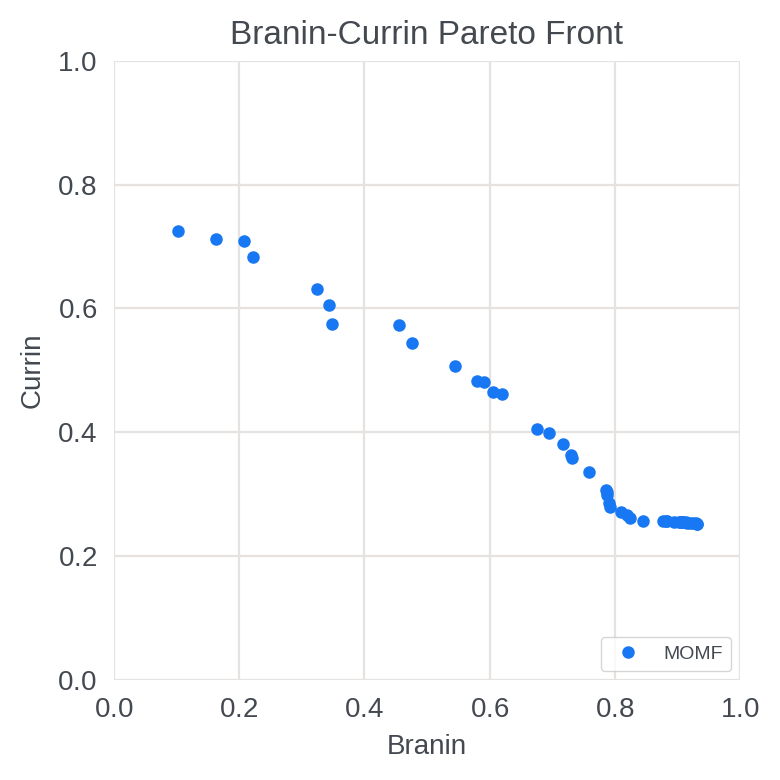

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
axes.plot(
    final_PF[:, 0].detach().cpu().numpy(),
    final_PF[:, 1].detach().cpu().numpy(),
    "o",
    markersize=3.5,
    label="MOMF",
)
axes.set_title("Branin-Currin Pareto Front", fontsize="12")
axes.set_xlabel("Branin", fontsize="10")
axes.set_ylabel("Currin", fontsize="10")
axes.set_xlim(0, 1)
axes.set_ylim(0, 1)
axes.tick_params(labelsize=10)
axes.legend(loc="lower right", fontsize="7", frameon=True, ncol=1)
plt.tight_layout()

# Comparison of MOMF with single-fidelity multi-objective optimization using qEHVI 

In this section, we draw a comparison of the MOMF with qEHVI. This section parallels the last, again running 30 iterations and defining helper functions for qEHVI similar to those used for MOMF. 

**Note: Most of the material for qEHVI example has been taken from [3]**

[3] [Constrained, Parallel, Multi-Objective BO in BoTorch with qNEHVI, and qParEGO](https://botorch.org/tutorials/constrained_multi_objective_bo)

Here we define a wrapper function for single-fidelity multi-objective qEHVI optimization that appends a column of ones (representing highest fidelity) around the Branin-Currin function.

In [13]:
def get_obj_MO(X: torch.Tensor) -> torch.Tensor:
    """
    Get the Branin-Currin objective at X.

    Since MO-only optimization only evaluates at the highest fidelity,
    a column of ones is added to the input to be consistent with the
    objective function definition.
    """
    h_fid = torch.ones(*X.shape[:-1], 1, **tkwargs)
    X = torch.cat([X, h_fid], dim=-1)
    y = BC(X)
    return y

### Data Initialization qEHVI 

For qEHVI, we initialize with one point to keep the initial cost low. We do not aim to make the initial costs the same, but for all cases the initial costs of the MOMF are lower when the fidelity is drawn in a probabilistic fashion.

In [14]:
def gen_init_data_MO(dim_x: int, points: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """Generate random training data."""
    train_x = torch.rand(size=(points, dim_x), **tkwargs)
    train_obj = get_obj_MO(train_x)
    return train_x, train_obj

### Helper function to optimize acquisition function 
This is a helper function that initializes and optimizes the acquisition function qEHVI and returns the new_x and new_obj. The problem is called from within this helper function.

A simple initialization heuristic is used to select the 20 restart initial locations from a set of 1024 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

In [15]:
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
)


def optimize_MO_and_get_obs(
    model: SingleTaskGP,
    train_obj: torch.Tensor,
    sampler: SobolQMCNormalSampler,
    ref_point: torch.Tensor,
    standard_bounds: torch.Tensor,
    BATCH_SIZE_MO: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Optimize the qEHVI acquisition function and return a new candidate and observation.
    """
    # partition non-dominated space into disjoint rectangles
    partitioning = FastNondominatedPartitioning(
        ref_point=torch.tensor(ref_point, **tkwargs), Y=train_obj
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point,  # use a known reference point
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE_MO,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=standard_bounds)
    new_obj = get_obj_MO(new_x)
    return new_x, new_obj

### Running qEHVI optimization for multiple Trials

We run 30 iterations to optimize the Branin-Currin functions using qEHVI. The Bayesian loop works almost the same as the one we ran early with MOMF:

1. An initial data is generated and a model initialized using this data.
2. The models are used to generated an acquisition function that gives us a suggestion for new input parameters
3. The objective function is evaluated at the suggested new_x and returns a new_obj.
4. The models are updated with the new points and then are used again to make the next prediction.

In [16]:
# Intializing train_x to zero
train_xMO = torch.zeros(
    n_INITMO + n_BATCH * BATCH_SIZE, dim_xMO, **tkwargs
)
# Intializing train_obj to zero
train_objMO = (
    torch.zeros(n_INITMO + n_BATCH * BATCH_SIZE, dim_yMO, **tkwargs)
)
torch.manual_seed(0)
train_xMO[:n_INITMO, :], train_objMO[:n_INITMO, :] = gen_init_data_MO(
    dim_xMO, n_INITMO
)
mll_MO, model_MO = initialize_model(
    train_xMO[:n_INITMO, :], train_objMO[:n_INITMO, :]
)

# Generate Sampler
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

for iteration in tqdm(range(0, n_BATCH)):
    # run N_BATCH rounds of BayesOpt after the initial random batch
    fit_gpytorch_mll(mll=mll_MO)  # Fit the model

    # Updating indices used to store new observations
    lower_index = n_INITMO + iteration * BATCH_SIZE
    upper_index = n_INITMO + iteration * BATCH_SIZE + BATCH_SIZE
    # optimize acquisition functions and get new observations
    new_x, new_obj = optimize_MO_and_get_obs(
        model=model_MO,
        train_obj=train_objMO[:upper_index, :],
        sampler=sampler,
        ref_point=ref_pointMO,
        standard_bounds=standard_boundsMO,
        BATCH_SIZE_MO=BATCH_SIZE,
    )
    # Updating train_x and train_obj
    train_xMO[lower_index:upper_index, :] = new_x
    train_objMO[lower_index:upper_index, :] = new_obj
    # reinitialize the models so they are ready for fitting on next iteration
    mll_MO, model_MO = initialize_model(train_xMO[:upper_index, :], train_objMO[:upper_index, :])

100%|██████████| 30/30 [01:50<00:00,  3.69s/it]


### Evaluating the hypervolume for each iteration

As before, we are interested in the Pareto front at the highest fidelity after the MOMF. In this section we only show the evolution of the mean hypervolume for both MOMF and qEHVI. The calculation for the MOMF is done in a similar fashion as before, but now for each iteration.

The following code loops over the number of trials and the number of iterations within a single trial. It works in the following steps: 
1. At the start of each iteration a model is trained on the MOMF data.
2. We generate a posterior mean from the model and calculated the dominated set from these 10000 points.
3. This dominated set is used to estimate the hypervolume and then the next iteration is started where the model now takes n+1 data points

**The test points used here are already generated before for evaluation of MOMF**


In [17]:
%%time
# Generating the final Pareto front by fitting a GP to MOMF data and evaluating the
# GP posterior at the highest fidelity with 10000 random points

# Array that contains hypervolume for n_TRIALS
hv_MOMF = np.zeros(train_obj.shape[0])
# Loop to get evolution of hypervolume during MOMF optimization.
for i in trange(n_INIT, train_obj.shape[0]):
    hv_MOMF[i], _ = get_pareto(train_x[:i, :], train_obj[:i, :-1], test_x)

 25%|██▌       | 15/60 [00:12<00:51,  1.14s/it]/mnt/xarfuse/uid-28646/3942ec4c-seed-nspid4026533215_cgpid2605254-ns-4026533212/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/mnt/xarfuse/uid-28646/3942ec4c-seed-nspid4026533215_cgpid2605254-ns-4026533212/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/mnt/xarfuse/uid-28646/3942ec4c-seed-nspid4026533215_cgpid2605254-ns-4026533212/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/mnt/xarfuse/uid-28646/3942ec4c-seed-nspid4026533215_cgpid2605254-ns-4026533212/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/mnt/xarfuse/uid-28646/3942ec4c-seed-nspid4026533215_cgpid2605254-ns-4026533212/linear_operator/utils/cholesky.py:40: NumericalWarnin

CPU times: user 54min 36s, sys: 59.1 s, total: 55min 35s
Wall time: 1min 23s


For the qEHVI the hypervolume calculation is more straightforward. We calculated at each iteration the set of non-dominated points from the training data and use that to estimate the hypervolume.

In [18]:
# Since the MO data is already at highest fidelity,
# we can calculate the evolution of hypervolume directly from data

hv_MO = np.zeros(train_objMO.shape[0])
# Loop to get evolution of hypervolume per iteration
for i in range(train_objMO.shape[0]):
    # Calculating Non-dominated points
    pareto_maskMO = is_non_dominated(train_objMO[:i, :])
    # Used to calculate hypervolume
    box_decomp = DominatedPartitioning(
        torch.tensor(ref_pointMO, **tkwargs),
        train_objMO[:i, :][pareto_maskMO],
    )
    hv_MO[i] = box_decomp.compute_hypervolume().item()

In [19]:
# Cost calculation for both MOMF and MO
cost_single = cost_func(train_x[:, -1])
cost_MOMF = torch.cumsum(cost_single, axis=0)
# Generating ones equal to number of iterations for MO only-optimization
ones = torch.ones(train_objMO.shape[0], **tkwargs)
cost_singleMO = cost_func(ones)
cost_MO = torch.cumsum(cost_singleMO, axis=0)

In [20]:
# Converting to Numpy arrays for plotting
cost_MOMF = cost_MOMF.cpu().numpy()
cost_MO = cost_MO.cpu().numpy()
# The approximate max hypervolume taken by evaluating the BC function offline with random 50000 points
true_hv = 0.5235514158034145

For plotting purposes we calculate the cost of both MOMF and MO using the last dimension of the training input data.

### Results

The following plot shows, for each iteration and for both MOMF and qEHVI, the hypervolume (as a percentage of the true hypervolume) and the cost (shown on a log scale).

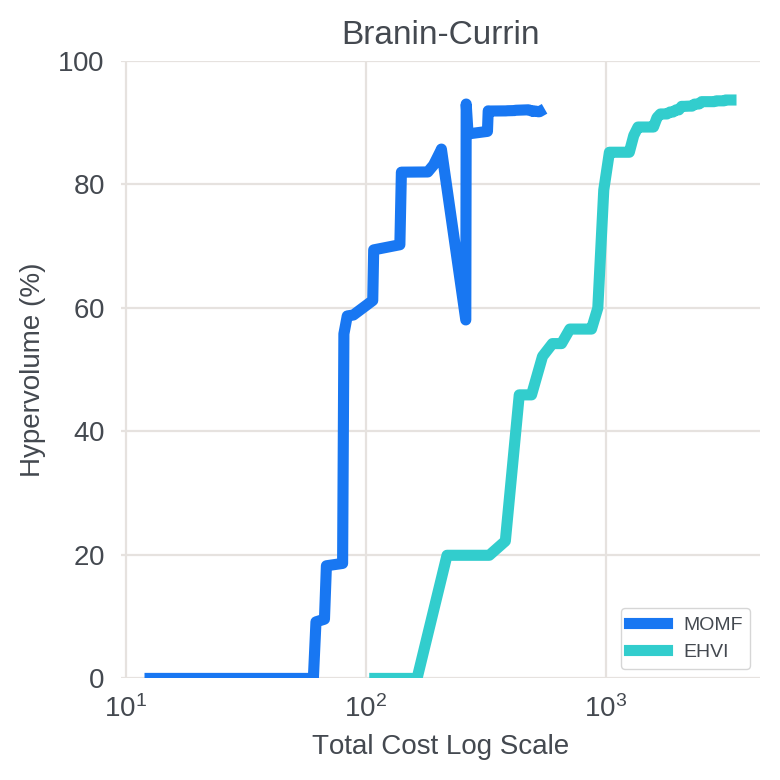

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
ax.plot(
    cost_MOMF[n_INIT :],
    hv_MOMF[n_INIT : ] / true_hv * 100,
    label="MOMF"
)
ax.plot(
    cost_MO[n_INITMO:],
    hv_MO[n_INITMO:] / true_hv * 100,
    label="EHVI"
)

ax.set_title("Branin-Currin", fontsize="12")
ax.set_xlabel("Total Cost Log Scale", fontsize="10")
ax.set_ylabel("Hypervolume (%)", fontsize="10")
ax.set_ylim(0, 100)
ax.tick_params(labelsize=10)
ax.legend(loc="lower right", fontsize="7", frameon=True, ncol=1)
plt.xscale("log")
plt.tight_layout()